In [1]:
import argparse
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset_builder, load_dataset, load_from_disk
from torch.utils.data import Dataset, DataLoader
import os
import json
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm
import random
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict

from finetune import CloneDetector

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Functions

In [2]:
def find_threshold(scores, labels, metric='f1'):
    # metric: 'acc' or 'f1'

    for label in labels:
        assert abs(label - 1) < 1e-10 or abs(label) < 1e-10
    assert metric in ['acc', 'f1']

    arr = sorted(list(zip(scores, labels)), key=lambda x: x[0])

    pre = 0.0
    post = sum(labels)

    max_eval, best_threshold = 0.0, arr[0][0]
    for i in range(len(arr) - 1):
        pre += arr[i][1]
        post -= arr[i][1]

        tp = post
        fp = len(arr) - i - post
        fn = pre
        tn = (i-pre)

        acc = (tp + tn) / len(arr)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)

        eval = {'acc': acc, 'f1': f1}

        if max_eval < eval[metric]:
            max_eval = acc
            best_threshold = (arr[i][0] + arr[i][1]) / 2
    return best_threshold

def accuracy(scores, labels, threshold):
    return np.mean(((scores > threshold).astype(np.int32) == labels).astype(np.float32)).tolist()


def f1_score(scores, labels, threshold):
    return metrics.f1_score((scores > threshold), labels)
    
class AugmentedDataset(Dataset):
    def __init__(self, inputs):
        self.data = inputs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    


# Load Model

In [3]:
%%time


model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
batch_size = 8

def tokenize(code):
    return tokenizer(code, return_tensors="pt", truncation=True, padding="longest", max_length=512)

def collate_fn(items):
    x = {}

    code1, code2, labels = [], [], []
    for item in items:
        code1.append(item['code1'])
        code2.append(item['code2'])
        labels.append(item['similar'])

    x['code1'] = tokenize(code1)
    x['code2'] = tokenize(code2)
    x['labels'] = torch.tensor(labels, dtype=torch.float32)

    return x



ckpt_path = '/mnt/ssd/696ds/checkpoints/0326_codebert-base_lr3.0e-07-w5000/step200000.pt'
# model = CloneDetector(model_name, device)
model = torch.load(ckpt_path).to(device)
model.device = device
model.train(False)

CPU times: user 1.71 s, sys: 955 ms, total: 2.66 s
Wall time: 2.8 s


CloneDetector(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

# Find threshold using val data from a different fold (fold 5/5)

In [4]:
%%time
batch_size = 8
n_th = 30000

dataset = load_from_disk("/mnt/ssd/696ds_data/PoolC/original/5-fold-clone-detection-600k-5fold")["val"]
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

CPU times: user 78 ms, sys: 94.8 ms, total: 173 ms
Wall time: 171 ms


In [5]:
%%time
scores_list, labels_list = [], []
pbar = tqdm(dataloader, total=(n_th+batch_size-1) // batch_size)
for i, batch in enumerate(pbar):
        
    if batch_size * i >= n_th:
        break
    
    labels = batch['labels']
    
    scores = model(batch).to('cpu')
    
    scores, labels = scores.tolist(), labels.tolist()
    
    scores_list += scores if type(scores) == list else [scores]
    labels_list += labels if type(labels) == list else [labels]
    
scores, labels = np.array(scores_list), np.array(labels_list)
threshold = find_threshold(scores, labels)
acc, f1 = accuracy(scores, labels, threshold), f1_score(scores, labels, threshold)
print(threshold)

  0%|          | 0/3750 [00:00<?, ?it/s]

0.8031601309776306
CPU times: user 7min 9s, sys: 25.5 s, total: 7min 34s
Wall time: 5min 42s


In [6]:
# threshold = 0.8414617776870728

# Read Augmented Dataset

In [7]:
save_dir = "/mnt/ssd/696ds_data/PoolC/train/032923/"
print(os.listdir(save_dir))
save_path = os.path.join(save_dir, "augmented_['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'].json")

p2index = {f'0.{i+1}': i for i in range(9)}
p2index['1.0'] = 9
# p2index = {"0.5": 0}

with open(save_path, 'r') as f:
    json_data = json.load(f)
    print(type(json_data))
    
data = json_data['data']

["augmented_['0.5'].json", "augmented_['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'].json"]
<class 'dict'>


In [8]:
print(json_data['data'][0]['original'])

{'code1': 'n, m, l = map(int, input().split())\na = [list(map(int, input().split())) for _ in range(n)]\nb = [list(map(int, input().split())) for _ in range(m)]\nc = [[0 for i in range(l)] for j in range(n)]\n\nfor i in range(n):\n    for j in range(l):\n        for k in range(m):\n            c[i][j] += a[i][k] * b[k][j]\nfor i in range(n):\n    print(" ".join(map(str, c[i])))\n\n', 'code2': "def main():\n\n    N, D = map(int, input().split())\n    ans = 0\n    for _ in range(N):\n        x, y = map(int, input().split())\n        if x*x + y* y <= D*D:\n            ans += 1\n    return ans\n\nif __name__ == '__main__':\n    print(main())\n", 'similar': 0, 'pair_id': None, 'question_pair_id': 3686761737148.0, 'code1_group': 60, 'code2_group': 96}


# Evaluate on the PoolC dataset (positive only)

In [9]:
def func(datapoints):
        
    dataset = AugmentedDataset(datapoints)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    scores_list = []
    labels_list = []
    for j, batch in enumerate(dataloader):

        labels = batch['labels']
        scores = model(batch).to('cpu')

        labels, scores = labels.tolist(), scores.tolist()
        labels_list += labels if type(labels) == list else [labels]
        scores_list += scores if type(scores) == list else [scores]


    scores = np.array(scores_list)
    labels = np.array(labels_list)
    return np.array(scores_list), np.array(labels_list)

def original_scores(n):
    dataset1 = []
    for i in range(len(data)):
        if len(dataset1) == n:
            break
            
        dataset1.append(
            {
                'code1': data[i]['original']['code1'],
                'code2': data[i]['original']['code2'],
                'similar': data[i]['original']['similar']
            }
        )

    scores1, labels1 = func(dataset1)
    acc1 = accuracy(scores1, labels1, threshold)
    f1_1 = f1_score(scores1, labels1, threshold)
    
    
    results = {
        'Accuracy': acc1,
        'F1': f1_1,
        'Mean': np.mean(scores1),
        'Standard Deviation': np.std(scores1),
        'Same Prediction': 1.0,
        'Mean Absolute Difference': 0.0,
        'Root Mean Squared Difference': 0.0
        
    }
    
    return scores1, results
    

def augmented_scores(p, n, scores1):
    index = p2index[p]
    dataset2 = []
    for i in range(len(data)):
        if len(dataset2) == n:
            break
            
        dataset2.append(
            {
                'code1': data[i]['augmented'][p2index[p]]['code1'],
                'code2': data[i]['original']['code2'],
                'similar': data[i]['original']['similar']
            }
        )
            
    scores, labels = func(dataset2)

    acc = accuracy(scores, labels, threshold)
    f1 = f1_score(scores, labels, threshold)

    
    results = {
        'Accuracy': acc,
        'F1': f1,
        'Mean': np.mean(scores),
        'Standard Deviation': np.std(scores),
        'Same Prediction': np.mean((scores1 > threshold) == (scores > threshold)),
        'Mean Absolute Difference': np.mean(np.abs(scores1-scores)),
        'Root Mean Squared Difference': np.sqrt(np.mean((scores1 - scores) ** 2))
        
    }
    
    
    print('p:', p)
    for key, value in results.items():
        print(f"{key:<30}: {value:>3.3f}")
    print()
    return results

In [10]:
%%time
n_pc = 30000
results = {}

scores1, results1 = original_scores(n_pc)
results['0.0'] = results1

targets = sorted(list(p2index.keys()), key=lambda x:float(x))
# targets = ['0.2', '0.5', '0.7', '1.0']
for p in targets:
    results[p] = augmented_scores(p, n_pc, scores1)

p: 0.1
Accuracy                      : 0.887
F1                            : 0.895
Mean                          : 1.656
Standard Deviation            : 1.988
Same Prediction               : 0.992
Mean Absolute Difference      : 0.054
Root Mean Squared Difference  : 0.131

p: 0.2
Accuracy                      : 0.886
F1                            : 0.895
Mean                          : 1.649
Standard Deviation            : 1.982
Same Prediction               : 0.988
Mean Absolute Difference      : 0.087
Root Mean Squared Difference  : 0.179

p: 0.3
Accuracy                      : 0.885
F1                            : 0.894
Mean                          : 1.637
Standard Deviation            : 1.974
Same Prediction               : 0.983
Mean Absolute Difference      : 0.119
Root Mean Squared Difference  : 0.239

p: 0.4
Accuracy                      : 0.884
F1                            : 0.892
Mean                          : 1.624
Standard Deviation            : 1.966
Same Prediction    

In [11]:

targets = ["0.0"] + targets
x = [float(target) for target in targets]

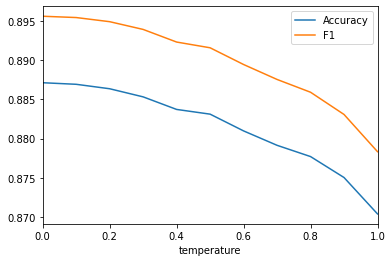

In [12]:


plt.plot(x, [results[p]['Accuracy'] for p in targets], label='Accuracy')
plt.plot(x, [results[p]['F1'] for p in targets], label='F1')
plt.xlabel('temperature')
plt.xlim((0.0, 1.0))
plt.legend()
plt.show()

In [13]:
# precison, only positive

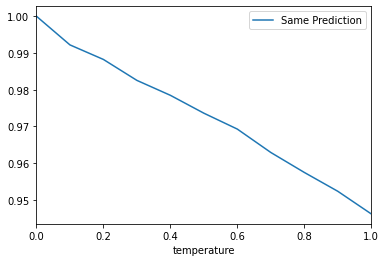

In [14]:
plt.plot(x, [results[p]['Same Prediction'] for p in targets], label='Same Prediction')
plt.xlabel('temperature')
plt.xlim((0.0, 1.0))
plt.legend()
plt.show()

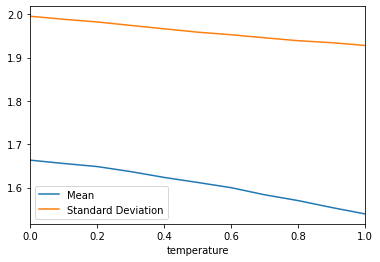

In [15]:

plt.plot(x, [results[p]['Mean'] for p in targets], label='Mean')
plt.plot(x, [results[p]['Standard Deviation'] for p in targets], label='Standard Deviation')
plt.xlabel('temperature')
plt.xlim((0.0, 1.0))
plt.legend()
plt.show()


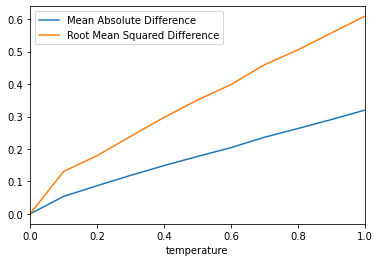

In [16]:

plt.plot(x, [results[p]['Mean Absolute Difference'] for p in targets], label='Mean Absolute Difference')
plt.plot(x, [results[p]['Root Mean Squared Difference'] for p in targets], label='Root Mean Squared Difference')
plt.xlabel('temperature')
plt.xlim((0.0, 1.0))
plt.legend()
plt.show()